# Modeling

### Import Libraries

In [502]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
%matplotlib inline

### Create a Pipeline

In [547]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Function for getting feature names

In [261]:
def get_feature_df(grid_search, features):
    """
    Return the feature names and coefficients from the final classifier of the
    best pipeline found by GridSearchCV. See https://git.io/vPWLI.

    Params
    ------
    grid_search: GridSearchCV object
        A post-fit GridSearchCV object where the estimator is a Pipeline.
    features: list
        initial feature names

    Returns
    -------
    pandas.DataFrame
        Dataframe of feature name and coefficient values
    """
    features = np.array(features)
    pipeline = grid_search.best_estimator_
    for name, transformer in pipeline.steps:
        if name.startswith('select'):
            X_index = np.arange(len(features)).reshape(1, -1)
            indexes = transformer.transform(X_index).tolist()
            features = features[indexes]
    step_name, classifier = pipeline.steps[-1]
    coefficients, = classifier.coef_
    feature_df = pd.DataFrame.from_items([
        ('feature', features),
        ('coefficient', coefficients),
    ])
    return feature_df

### Predict
- added SMOTE option
- added PCA to pipeline and see if time and score increase

In [399]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

def fit_predict(model, X_train, X_test, y_train, y_test, smote=False):
    '''fit pipeline using given model, and return predictions'''
    
    param_grid = model['params']
    model = model['model']
        
    if smote:
        # Bundle preprocessing and modeling code in a pipeline
        my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('smote', SMOTE()),
                                      ('under', RandomUnderSampler()),
#                                       ('pca', TruncatedSVD()),
                                      ('model', model)
                                     ])
    else:
        # Bundle preprocessing and modeling code in a pipeline
        my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                       ('pca', TruncatedSVD()),
                                      ('model', model)
                                     ])

    search = GridSearchCV(estimator=my_pipeline,
             param_grid=param_grid, n_jobs=-1, verbose=2, cv=3)
    
    search.fit(X_train, y_train)
        

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    # Preprocessing of validation data, get predictions
    test_preds = search.predict(X_test)
    train_preds = search.predict(X_train)
    
    return test_preds, train_preds

## Evaluate
What are the most important things to look for with regression?

In [166]:
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline


def plot_confusion_matrix(y_true, y_preds):
    # Print confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_preds)
    
    # Create the basic matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)
    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')
    # Add a legend
    plt.colorbar();
    plt.show();

In [189]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def metrics(model_name, y_train, y_test, y_train_pred, y_test_pred):
    '''Print out the evaluation metrics for a given models predictions'''
    print(f'Model: {model_name}', )
    print('-'*60)
    plot_confusion_matrix(y_test, y_test_pred)
    print('-'*60)
    print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}')
    print(f'train accuracy: {accuracy_score(y_train, y_train_pred)}')
    print('-'*60)
    print('\ntest report:\n' + classification_report(y_test, y_test_pred))
    print('~'*60)
    print('\ntrain report:\n' + classification_report(y_train, y_train_pred))    
    print('-'*60)
    

## Dataset

### Full

In [565]:
# full dataset
clean_df = pd.read_csv('../data/clean/tanzania.csv', index_col=0)
clean_df = clean_df.drop(['latitude', 'longitude'], axis=1)

y = clean_df[clean_df['target'] != -1]['target']
X = clean_df[clean_df['target'] != -1].drop(['target'], axis=1)

X_contest = pd.read_csv('../data/raw/X_test.csv')

numerical_cols = list(X.select_dtypes(include=np.number).columns)
categorical_cols = list(X.select_dtypes(exclude=np.number).columns)

In [567]:
X_contest.sample(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
2009,48869,3000.0,2013-01-30,Norad,1913,Norad,31.665248,-8.007653e+00,Kwa Mogelasopo,0,...,annually,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
8927,15591,7.0,2013-02-24,Germany Republi,1533,CES,37.230970,-3.194000e+00,Kwa Fineus,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
5445,7516,0.0,2012-10-22,Rwssp,0,DWE,0.000000,-2.000000e-08,Majimaji,0,...,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [568]:
# split full data
X_total_train, X_total_test, y_total_train, y_total_test = train_test_split(X, y, test_size=.3, random_state=42)

### Sub

In [569]:
# smaller dataset
smallest_num = clean_df['target'].value_counts().sort_values().values[0]
target_0 = clean_df[clean_df['target'] == 0].sample(smallest_num)
target_1 = clean_df[clean_df['target'] == 1].sample(smallest_num)
target_2 = clean_df[clean_df['target'] == 2].sample(smallest_num)

sampled_df = pd.concat([target_0, target_1, target_2])

In [570]:
sampled_df['target'].value_counts()

2    1579
1    1579
0    1579
Name: target, dtype: int64

In [571]:
X_sampled_df = sampled_df.drop('target', axis=1)
y_sampled_df = sampled_df['target']

In [572]:
# split sampled data
X_train, X_test, y_train, y_test = train_test_split(X_sampled_df, y_sampled_df, test_size=.3, random_state=42)

In [573]:
X_sampled_df.head()

,gps_height,basin,region,district_code,population,scheme_management,permit,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,age
40585,2090,Lake Nyasa,Iringa,4,200,VWC,False,swn 80,parastatal,never pay,soft,enough,shallow well,hand pump,19
40302,1164,Lake Rukwa,Rukwa,1,150,VWC,True,india mark ii,vwc,monthly,soft,enough,machine dbh,hand pump,15
50470,34,Ruvuma / Southern Coast,Lindi,13,96,VWC,True,nira/tanira,private operator,per bucket,salty,enough,shallow well,hand pump,23
31559,1249,Internal,Singida,1,240,VWC,True,afridev,vwc,never pay,soft,enough,machine dbh,hand pump,10
58491,1535,Rufiji,Iringa,4,120,VWC,True,gravity,vwc,annually,soft,enough,spring,communal standpipe,10


In [574]:
X_sampled_df.shape[0]

4737

### Smoted

In [575]:
sm = SMOTE()
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X)
X_smoted, y_smoted = sm.fit_resample(X_ohe, y)

In [576]:
X_smoted

<40236x3267 sparse matrix of type '<class 'numpy.float64'>'
	with 659846 stored elements in Compressed Sparse Row format>

In [577]:
y_smoted.value_counts()

2    13412
1    13412
0    13412
Name: target, dtype: int64

In [578]:
X_smoted_train, X_smoted_test, y_smoted_train, y_smoted_test = train_test_split(X_smoted, y_smoted, test_size=.25, random_state=42)

# Models
- LinearSVC
- k-NN
- Support Vector Machine Algorithm
- XGBoost
- Random Forest

## LinearSVC

### Why LinearSVC
The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit"
hyperplane that divides, or categorizes, your data. 

It has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

LinearSVC is another (faster) implementation of Support Vector Classification for the case of a linear kernel.

### Hyperparameters

In [499]:
lsvc_params = {
    # 
    'model__C': [.1, 1, 10], 
    'model__tol': [1,0.1,0.01],
    'model__max_iter': [100000],
    'model__penalty': ['l1', 'l2'],
    'model__multi_class': ['ovr']
}

# Best parameter (CV score=0.630):
# {'model__C': 0.1, 'model__max_iter': 100000, 'model__multi_class': 'crammer_singer', 'model__penalty': 'l1', 'model__tol': 0.1}

### Fitting LinearSVC

In [500]:
from sklearn.svm import LinearSVC

lsvc = { 'model': LinearSVC(random_state=42), 'params': lsvc_params }

lsvc_test_preds, lsvc_train_preds = fit_predict(lsvc, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:    8.4s remaining:    1.3s


Best parameter (CV score=0.622):
{'model__C': 0.1, 'model__max_iter': 100000, 'model__multi_class': 'ovr', 'model__penalty': 'l2', 'model__tol': 1}


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   34.2s finished


### Evaluating LinearSVC

Model: LinearSVC
------------------------------------------------------------


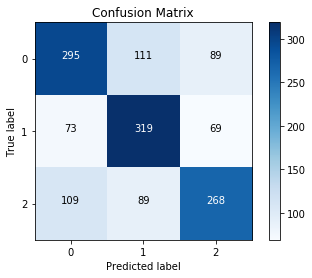

------------------------------------------------------------
test accuracy: 0.620253164556962
train accuracy: 0.6458521870286577
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       495
           1       0.61      0.69      0.65       461
           2       0.63      0.58      0.60       466

    accuracy                           0.62      1422
   macro avg       0.62      0.62      0.62      1422
weighted avg       0.62      0.62      0.62      1422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1084
           1       0.64      0.71      0.67      1118
           2       0.68      0.60      0.64      1113

    accuracy                           0.65      3315
   macro avg       0.65      0.65      0.64      3315
weighted avg 

In [501]:
metrics('LinearSVC', y_train, y_test, lsvc_train_preds, lsvc_test_preds)

There is a debate that LinearSVC is not a good fit for multi-class classification problems.

There are some ways to adjust for it: 
- using the 'crammer_singer' algorithm, or the 'ovr' (one-vs-rest)

## KNN

### Why KNN
KNNs are a non-parametric, lazy learning algorithm. It makes no underlying assumptions about the distribution of data. 

No training is necessary! 

KNN makes predictions just-in-time by calculating the similarity between an input sample and each training instance.

It is a Simple algorithm — to explain and understand/interpret. It is versatile — useful for classification or regression.

### Hyperparameters

In [496]:
knn_params = {
#     'pca__n_components': range(80, 120, 20),
    # amount of neighbors
    'model__n_neighbors': [1],
    # leaf size
    'model__leaf_size': [1],
    'model__weights': ['distance'],
    'model__p': [2]
}

### Fitting KNN

In [497]:
from sklearn.neighbors import KNeighborsClassifier
knn = { 'model': KNeighborsClassifier(), 'params': knn_params }

knn_test_preds, knn_train_preds = fit_predict(knn, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Best parameter (CV score=0.610):
{'model__leaf_size': 1, 'model__n_neighbors': 1, 'model__p': 2, 'model__weights': 'distance'}


### Evaluating KNN

Model: k-NN
------------------------------------------------------------


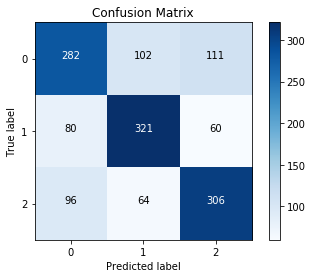

------------------------------------------------------------
test accuracy: 0.6392405063291139
train accuracy: 0.9990950226244344
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       495
           1       0.66      0.70      0.68       461
           2       0.64      0.66      0.65       466

    accuracy                           0.64      1422
   macro avg       0.64      0.64      0.64      1422
weighted avg       0.64      0.64      0.64      1422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1084
           1       1.00      1.00      1.00      1118
           2       1.00      1.00      1.00      1113

    accuracy                           1.00      3315
   macro avg       1.00      1.00      1.00      3315
weighted avg

In [498]:
metrics('k-NN', y_train, y_test, knn_train_preds, knn_test_preds)

## SVC

## Why SVC

### Hyperparameters

In [199]:
svc_params = {
}

### Fitting SVC

In [ ]:
from sklearn.svmm import SVC

svc = { 'model': SVC(random_state=42), 'params': svc_params }

svc_test_preds, svc_train_preds = fit_predict(svc, X_train, X_test, y_train, y_test)

### Evaluating SVC

In [ ]:
metrics('SVC', y_train, y_test, svc_train_preds, svc_test_preds)

## XGBoost

### Why XGBoost

### Hyperparameters

In [462]:
xgb_params = {
#     'pca__n_components': range(20, 60, 20),
    'model__colsample_bytree': [.6],       # how many features to use per estimator/tree
    'model__eta': [.01],                   # learning rate
    'model__n_estimators': [1000],         # how many models/estimators/trees to make
    'model__gamma': [4],                   # larger gamma, more conservitive. lower means more overfitting
    'model__max_depth': [15],              # higher number means more overfitting
    'model__objective': ['multi:softmax'], # for multiclass 
    'model__num_class': [3],               # for multiclass
    'model__eval_metric': ['merror'],      # for multiclass
}

### Fitting XGBoost

In [579]:
X_smoted_train

<30177x3267 sparse matrix of type '<class 'numpy.float64'>'
	with 494862 stored elements in Compressed Sparse Row format>

In [553]:
from xgboost import XGBClassifier

xgb = { 'model': XGBClassifier(random_state=42), 'params': xgb_params }

xgb_test_preds, xgb_train_preds = fit_predict(xgb, X_total_train, X_total_test, y_total_train, y_total_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [516]:
test_xgb = XGBClassifier(random_state=42)
test_xgb.fit(X_smoted_train, y_smoted_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [517]:
y_smoted_pred = test_xgb.predict(X_smoted_test)

In [519]:
print(classification_report(y_smoted_test, y_smoted_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      3343
           1       0.89      0.90      0.89      3345
           2       0.91      0.73      0.81      3371

    accuracy                           0.84     10059
   macro avg       0.85      0.85      0.84     10059
weighted avg       0.85      0.84      0.84     10059



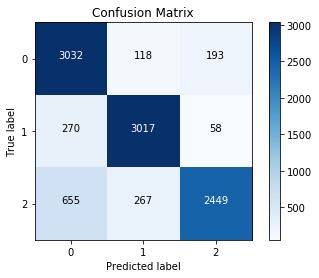

In [548]:
plot_confusion_matrix(y_smoted_test, y_smoted_pred)

### Evaluating XGBoost

Model: XGBoost, all data
------------------------------------------------------------


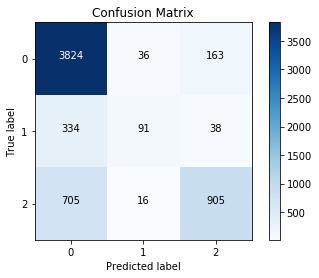

------------------------------------------------------------
test accuracy: 0.7886125654450262
train accuracy: 0.8231292517006803
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      4023
           1       0.64      0.20      0.30       463
           2       0.82      0.56      0.66      1626

    accuracy                           0.79      6112
   macro avg       0.75      0.57      0.61      6112
weighted avg       0.78      0.79      0.77      6112

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9389
           1       0.75      0.26      0.38      1116
           2       0.87      0.62      0.73      3754

    accuracy                           0.82     14259
   macro avg       0.81      0.62      0.67     14259
weighted avg

In [472]:
metrics('XGBoost, all data', y_total_train, y_total_test, xgb_train_preds, xgb_test_preds)

## Random Forest

### Fitting Random Forest

### Evaluating Random Forest

## Contest

In [ ]:
# submission = X_contest['status_group']
# submission.to_csv('submission_01.csv')
# X_contest.shape